# PASO 1: Instalar librerías¶

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## PASO 1.1: Importar herramientas de modelado y evaluación

In [10]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score
)

# PASO 2: Cargar dataset y crear variable objetivo

In [11]:
df_raw = pd.read_csv('retail_data_sample.csv')
# Crear variable objetivo: Compra_online
df_raw['ventas'] = (df_raw['total_sales'] > 1500 ).astype(int)
df_raw.head()

,customer_id,age,gender,income_bracket,loyalty_program,membership_years,churned,marital_status,number_of_children,education_level,...,holiday_season,season,weekend,customer_support_calls,email_subscriptions,app_usage,website_visits,social_media_engagement,days_since_last_purchase,ventas
0,40891,65,Male,High,Yes,9,No,Divorced,2,High School,...,No,Fall,No,9.0,Yes,Medium,92.0,Medium,56.0,1
1,267732,31,Female,Low,No,3,Yes,Single,0,Bachelor's,...,No,Summer,No,16.0,Yes,High,99.0,High,120.0,1
2,262622,52,Male,Medium,No,4,Yes,Single,3,Master's,...,Yes,Spring,No,13.0,Yes,Low,84.0,Medium,122.0,0
3,295896,64,Female,Medium,Yes,7,No,Single,2,Master's,...,Yes,Winter,Yes,7.0,Yes,High,25.0,High,174.0,1
4,208360,77,Other,Medium,No,8,Yes,Divorced,3,PhD,...,Yes,Spring,No,2.0,Yes,Low,95.0,Low,355.0,1


# Paso 3: Evaluación del modelo antes de limpiar los datos

In [12]:
# Crear variable objetivo
df_raw['ventas'] = (df_raw['total_sales'] > 1500 ).astype(int)# Seleccionar variables sin limpieza
df_before = df_raw[["unit_price", "quantity"]].dropna()
Xb = df_before.copy()
yb = df_raw.loc[df_before.index, "ventas"]


# División entrenamiento / prueba
Xb_train, Xb_test, yb_train, yb_test = train_test_split(Xb, yb, test_size=0.3, random_state=42)

# Modelo sin limpieza
model_before = LogisticRegression(max_iter=200)
model_before.fit(Xb_train, yb_train)

# Predicción y exactitud
yb_pred = model_before.predict(Xb_test)
acc_before = accuracy_score(yb_test, yb_pred)

print("✅ Exactitud antes de la limpieza:", round(acc_before, 4))

✅ Exactitud antes de la limpieza: 0.8607


# Paso 4: Preparación del dataset: limpieza, imputación y codificación

In [13]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

# Copia del dataset original
df_clean = df_raw.copy()

# Imputación de valores numéricos
imputer_unit_price = SimpleImputer(strategy='median')
df_clean['unit_price'] = imputer_unit_price.fit_transform(df_clean[['unit_price']])

imputer_quantity = SimpleImputer(strategy='mean')
df_clean['quantity'] = imputer_quantity.fit_transform(df_clean[['quantity']])


cols_to_drop = [
    'customer_id', 'transaction_id', 'transaction_date', 'last_purchase_date',
    'product_id', 'product_name', 'product_brand', 'product_manufacture_date', 'product_expiry_date',
    'promotion_id', 'promotion_start_date', 'promotion_end_date',
    'customer_zip_code', 'store_zip_code', 'customer_city', 'store_city', 'total_items_purchased',
    'customer_state', 'store_state', 'preferred_store' ,'max_single_purchase_value', 'min_single_purchase_value',
    'total_returned_items' ,'avg_spent_per_category','total_returned_value', "product_color",'store_location', 'transaction_hour','day_of_week', 'week_of_year', 'month_of_year', 'product_material',"churned"
    
]

df_clean = df_clean.drop(columns=[col for col in cols_to_drop if col in df_clean.columns])
# Variables numéricas y categóricas razonables para el modelo
categorical = ['gender', 'income_bracket', 'loyalty_program', 'marital_status', 'education_level',
               'occupation', 'season', 'weekend','payment_method', 'product_category','promotion_target_audience', 'promotion_channel','promotion_type' ,'promotion_effectiveness']

numerical = ['age', 'membership_years', 'number_of_children', 'avg_purchase_value', 
             'purchase_frequency', 'avg_discount_used', 'online_purchases', 
             'in_store_purchases', 'avg_items_per_transaction', 'avg_transaction_value',
             'product_rating', 'product_review_count', 'product_stock', 'product_return_rate',
             'product_size', 'product_weight', 'distance_to_store', 'holiday_season',
             'customer_support_calls', 'website_visits', 'days_since_last_purchase','total_transactions', "total_sales",'total_discounts_received','quantity' ,'unit_price','discount_applied' 
             , 'email_subscriptions'
            ,'app_usage','social_media_engagement'
            ]
# Filtrar el dataset para incluir solo estas variables (si existen)
vars_to_use = categorical + numerical + ['ventas']  # incluir la variable objetivo
df_model = df_clean[[col for col in vars_to_use if col in df_clean.columns]].copy()

from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# Imputar valores faltantes
for col in df_model.select_dtypes(include='number').columns:
    if df_model[col].isnull().sum() > 0:
        df_model[col].fillna(df_model[col].median(), inplace=True)
# Codificar variables categóricas
categorical_cols = df_model.select_dtypes(include=['object', 'category']).columns.tolist()

# Aplicar codificación one-hot
df_model = pd.get_dummies(df_model, columns=categorical_cols, drop_first=True)

# Convertir columnas booleanas a enteros
df_model = df_model.astype({col: int for col in df_model.columns if df_model[col].dtype == 'bool'})

# Escalar numéricas
scaler = MinMaxScaler()
numerical_scaled = [col for col in numerical if col in df_model.columns]
df_model[numerical_scaled] = scaler.fit_transform(df_model[numerical_scaled])

# Paso 5: Evaluación del modelo después de la limpieza

In [15]:
# Definir variables predictoras y objetivo usando el dataset limpio
Xc = df_model.drop(columns=['ventas', "total_sales"])
yc = df_model['ventas']

# División entrenamiento / prueba
Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, yc, test_size=0.3, random_state=42)

# Modelo después de la limpieza
model_after = LogisticRegression(max_iter=1000)
model_after.fit(Xc_train, yc_train)

yc_pred = model_after.predict(Xc_test)
acc_after = accuracy_score(yc_test, yc_pred)
print("✅ Exactitud después de limpieza:", round(acc_after, 2))

✅ Exactitud después (balanceado): 0.86


### Regresión logística

In [16]:
log_model = LogisticRegression(max_iter=300)
log_model.fit(Xc_train, yc_train)
log_model.fit(Xc_train, yc_train)
log_pred = log_model.predict(Xc_test)
log_prob = log_model.predict_proba(Xc_test)[:, 1]

print("📊 Logistic Regression Accuracy:", round(accuracy_score(yc_test, log_pred), 6))
print(classification_report(yc_test, log_pred))

📊 Logistic Regression Accuracy: 0.860667
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       418
           1       0.86      1.00      0.93      2582

    accuracy                           0.86      3000
   macro avg       0.43      0.50      0.46      3000
weighted avg       0.74      0.86      0.80      3000



/srv/conda/envs/notebook/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/srv/conda/envs/notebook/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/srv/conda/envs/notebook/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##### Curva ROC  y Matriz de Confusión

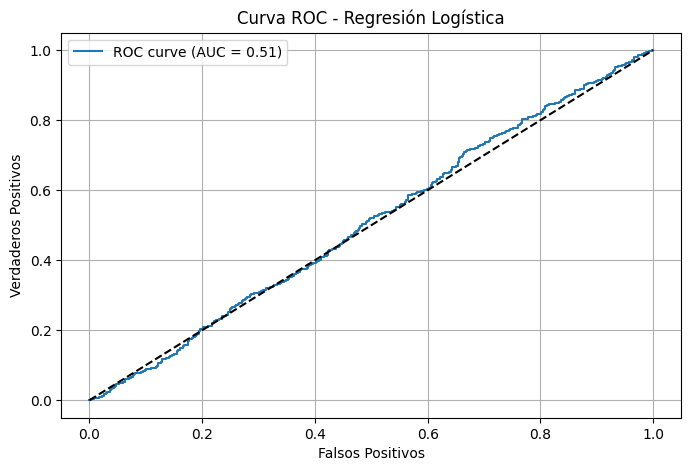

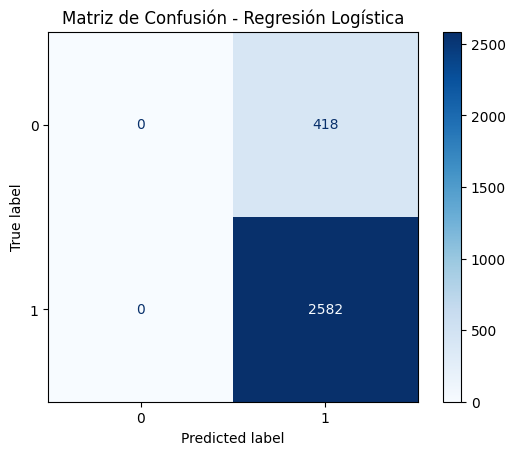

In [17]:
fpr, tpr, _ = roc_curve(yc_test, log_prob)
roc_auc = roc_auc_score(yc_test, log_prob)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Falsos Positivos')
plt.ylabel('Verdaderos Positivos')
plt.title('Curva ROC - Regresión Logística')
plt.legend()
plt.grid(True)
plt.show()

ConfusionMatrixDisplay.from_estimator(log_model, Xc_test, yc_test, cmap="Blues")
plt.title("Matriz de Confusión - Regresión Logística")
plt.show()

### KNN

In [18]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(Xc_train, yc_train)
knn_pred = knn_model.predict(Xc_test)

print("🔎 KNN Accuracy:", round(accuracy_score(yc_test, knn_pred), 4))
print(classification_report(yc_test, knn_pred))

🔎 KNN Accuracy: 0.8473
              precision    recall  f1-score   support

           0       0.22      0.04      0.07       418
           1       0.86      0.98      0.92      2582

    accuracy                           0.85      3000
   macro avg       0.54      0.51      0.49      3000
weighted avg       0.77      0.85      0.80      3000



### Árbol de decisión

🌳 Árbol de Decisión Accuracy: 0.736
              precision    recall  f1-score   support

           0       0.15      0.19      0.16       418
           1       0.86      0.82      0.84      2582

    accuracy                           0.74      3000
   macro avg       0.50      0.51      0.50      3000
weighted avg       0.76      0.74      0.75      3000



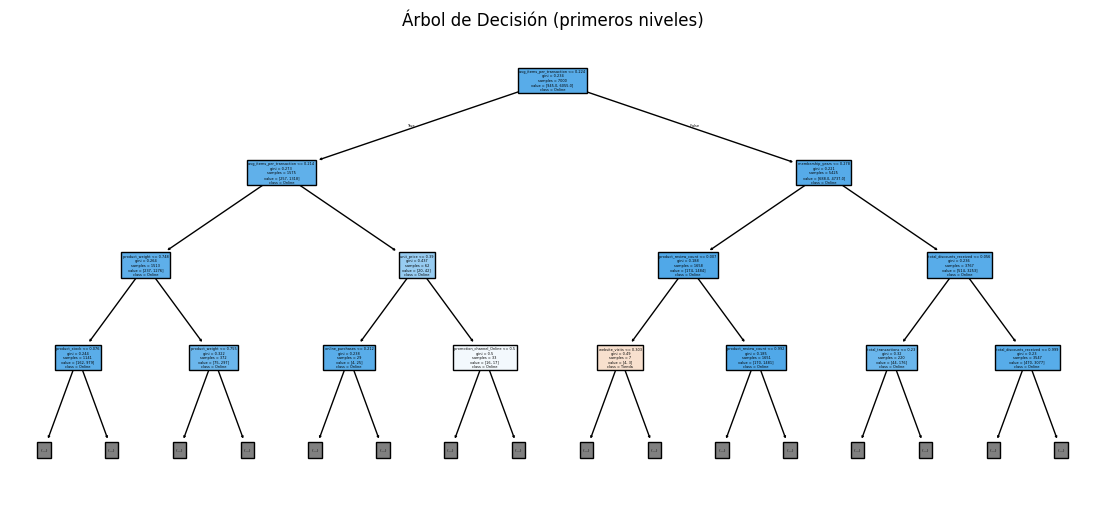

In [19]:
tree_model = DecisionTreeClassifier( random_state=42)
tree_model.fit(Xc_train, yc_train)
tree_pred = tree_model.predict(Xc_test)

print("🌳 Árbol de Decisión Accuracy:", round(accuracy_score(yc_test, tree_pred), 4))
print(classification_report(yc_test, tree_pred))

plt.figure(figsize=(14, 6))
plot_tree(tree_model, filled=True, max_depth=3, feature_names=Xc.columns, class_names=["Tienda", "Online"])
plt.title("Árbol de Decisión (primeros niveles)")
plt.show()

## Comparación modelos

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

models = {
    'KNN': KNeighborsClassifier(),
    'Regresión Logística': LogisticRegression(max_iter=300),
    'Árbol de Decisión': DecisionTreeClassifier()
}

for name, model in models.items():
    scores = cross_val_score(model, Xc_train, yc_train, cv=5, scoring='accuracy')
    print(f"{name}: Exactitud promedio (cross-val): {scores.mean():.3f} ± {scores.std():.3f}")


KNN: Exactitud promedio (cross-val): 0.849 ± 0.004
Regresión Logística: Exactitud promedio (cross-val): 0.865 ± 0.000
Árbol de Decisión: Exactitud promedio (cross-val): 0.752 ± 0.008
